In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten , InputLayer ,Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision ,Recall , Accuracy , F1Score
import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn.metrics import roc_curve , confusion_matrix ,auc
import seaborn as sns
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy

In [2]:
dataset, dataset_info = tfds.load('malaria',
                                  with_info = True,
                                  as_supervised= True,
                                  shuffle_files= True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteSUQAVJ/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmp7wm5my82tfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [4]:
dataset = dataset[0]

In [5]:
def split_dataset(dataset  , train_size , test_size ,val_size = 0):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(DATASET_SIZE*train_size))
  test_dataset = dataset.skip(int(DATASET_SIZE*train_size)).take(int(DATASET_SIZE*test_size))
  val_dataset = dataset.skip(int(DATASET_SIZE*train_size)).skip(int(DATASET_SIZE*test_size))
  return train_dataset, test_dataset ,val_dataset

In [6]:
lists = [10,10,3 ,4,5,6,8,9,0,14]
DATASET_SIZE = len(dataset)
TRAIN_RATIO =0.8
TEST_RATIO =0.1
VAL_RATIO =0.1

In [7]:
DATASET_SIZE

27558

In [8]:
train_dataset, test_dataset ,val_dataset = split_dataset(dataset  , TRAIN_RATIO , TEST_RATIO ,VAL_RATIO)

In [9]:
len(test_dataset)

2755

In [10]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
train_dataset.take(1).as_numpy_iterator()

In [12]:
list_train = list(train_dataset.take(1).as_numpy_iterator())

In [13]:
list_train

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  0)]

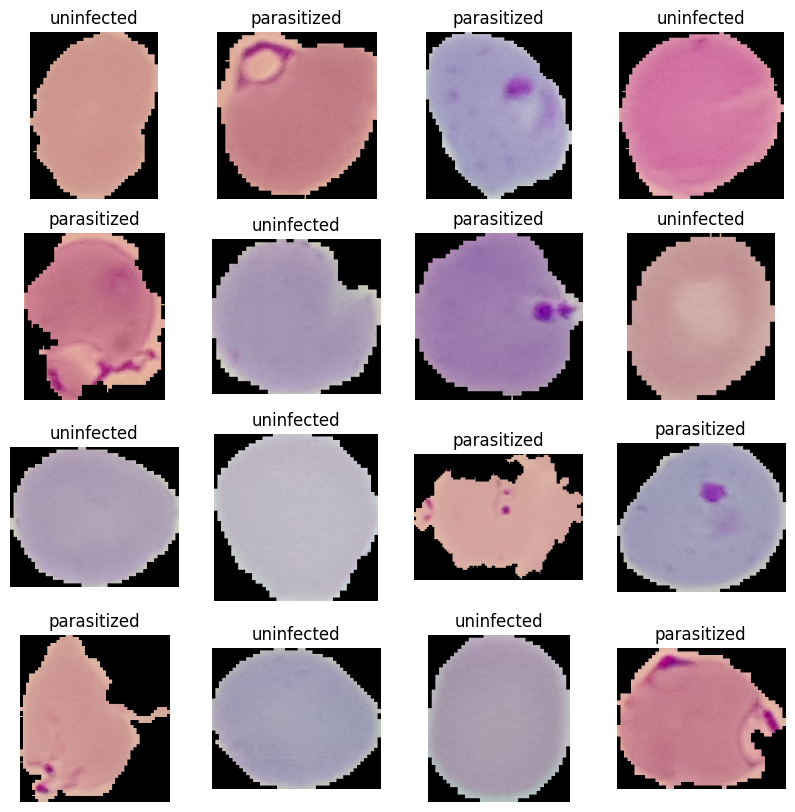

In [14]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [15]:
IMAGE_SIZE = 224

In [16]:
def image_resize_normalize (image , label ) :
  image = tf.image.resize(image , (IMAGE_SIZE ,IMAGE_SIZE)) /255
  return image , label

In [17]:
train_dataset =  train_dataset.map(image_resize_normalize)
test_dataset =  test_dataset.map(image_resize_normalize)
val_dataset = val_dataset.map(image_resize_normalize)

In [18]:
for data in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(121, 145, 3), dtype=uint8) tf.Tensor(0, shape=(), dtype=int64)


In [19]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [20]:
val_dataset = val_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [21]:
test_dataset = test_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(1).prefetch(tf.data.AUTOTUNE)

In [22]:
class Mymodel(tf.keras.models.Model):
    def __init__(self , IMAGE_SIZE):
        super(Mymodel , self).__init__()
        self.conv2D_1 = Conv2D(filters = 6 ,kernel_size= 3 ,padding ='valid' , activation = 'relu')
        self.batchnorm_1 = BatchNormalization()
        self.maxpooling_1 = MaxPooling2D(pool_size=(2,2) , strides=2)

        self.conv2D_2 = Conv2D(filters = 16 ,kernel_size= 3 ,padding ='valid' , activation = 'relu')
        self.batchnorm_2 = BatchNormalization()
        self.maxpooling_2 = MaxPooling2D(pool_size=(2,2) , strides=2)

        self.flatten = Flatten()

        self.dense_1 = Dense(100 , activation = 'relu')
        self.batchnorm_3 = BatchNormalization()


        self.dense_2 = Dense(10 , activation = 'relu')
        self.batchnorm_4 = BatchNormalization()


        self.output_layer = Dense(1 , activation = 'sigmoid')

    def call(self , inputs):

        x = self.conv2D_1(inputs)
        x = self.batchnorm_1(x)
        x = self.maxpooling_1(x)

        x = self.conv2D_2(x)
        x = self.batchnorm_2(x)
        x = self.maxpooling_2(x)

        x = self.flatten(x)

        x = self.dense_1(x)
        x = self.batchnorm_3(x)
        x = self.dense_2(x)
        x = self.batchnorm_4(x)
        output = self.output_layer(x)

        return output

In [23]:
input_tensor = Input(shape = (IMAGE_SIZE ,IMAGE_SIZE ,3))
model = Mymodel(IMAGE_SIZE)
output = model(input_tensor)

In [24]:
model

In [25]:
model.summary()

Model: "mymodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  168       
                                                                 
 batch_normalization (Batch  multiple                  24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  880       
                                                                 
 batch_normalization_1 (Bat  multiple                  64        
 chNormalization)                                                
                                                           

In [26]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

def F1Score(y_true, y_pred, precision=precision, recall=recall):
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    precision_result = precision.result()
    recall_result = recall.result()
    return (2 * precision_result * recall_result) / (precision_result + recall_result + tf.keras.backend.epsilon())

In [27]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc'),F1Score]

In [28]:
model.compile(optimizer = Adam(learning_rate= 0.01),
loss = BinaryCrossentropy(),
              metrics = metrics,
              )

In [29]:
history = model.fit(train_dataset , validation_data=val_dataset ,epochs=5 , verbose = 1)

Epoch 1/5
689/689 [==============================] - 102s 125ms/step - loss: 0.2823 - tp: 9918.0000 - fp: 1340.0000 - tn: 9680.0000 - fn: 1108.0000 - accuracy: 0.8890 - precision: 0.8810 - recall: 0.8995 - auc: 0.9492 - F1Score: 0.8219 - val_loss: 0.4544 - val_tp: 1355.0000 - val_fp: 411.0000 - val_tn: 979.0000 - val_fn: 12.0000 - val_accuracy: 0.8466 - val_precision: 0.7673 - val_recall: 0.9912 - val_auc: 0.9447 - val_F1Score: 0.8886
Epoch 2/5
689/689 [==============================] - 50s 73ms/step - loss: 0.1874 - tp: 10529.0000 - fp: 778.0000 - tn: 10244.0000 - fn: 495.0000 - accuracy: 0.9423 - precision: 0.9312 - recall: 0.9551 - auc: 0.9714 - F1Score: 0.9028 - val_loss: 0.2971 - val_tp: 1309.0000 - val_fp: 138.0000 - val_tn: 1260.0000 - val_fn: 50.0000 - val_accuracy: 0.9318 - val_precision: 0.9046 - val_recall: 0.9632 - val_auc: 0.9644 - val_F1Score: 0.9139
Epoch 3/5
689/689 [==============================] - 45s 65ms/step - loss: 0.1637 - tp: 10549.0000 - fp: 694.0000 - tn: 103

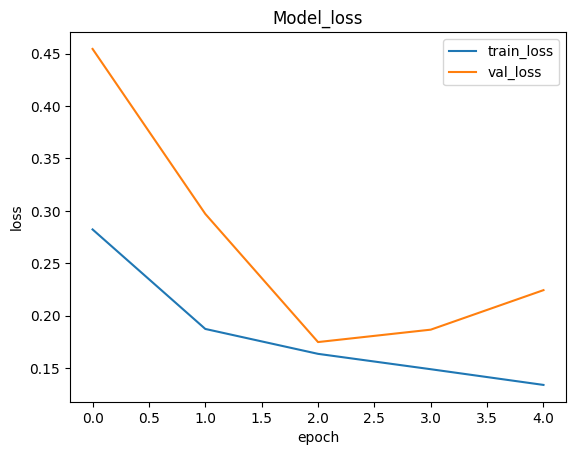

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

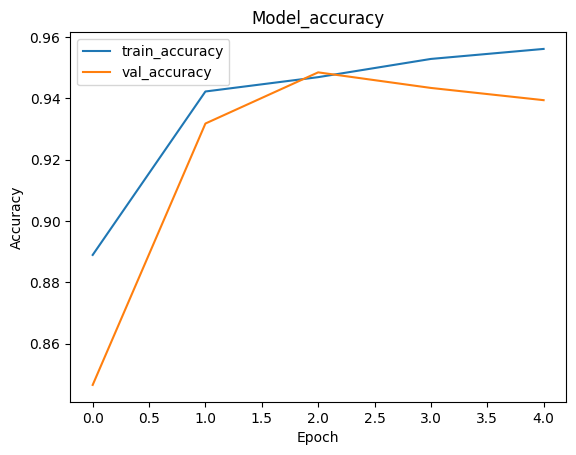

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [32]:
model.evaluate(test_dataset)

2755/2755 [==============================] - 24s 5ms/step - loss: 0.1945 - tp: 1354.0000 - fp: 124.0000 - tn: 1243.0000 - fn: 34.0000 - accuracy: 0.9426 - precision: 0.9161 - recall: 0.9755 - auc: 0.9817 - F1Score: 0.9368


[0.19448941946029663,
 1354.0,
 124.0,
 1243.0,
 34.0,
 0.9426497220993042,
 0.9161028265953064,
 0.9755043387413025,
 0.9817143082618713,
 0.9367799758911133]

In [33]:
def paraside_or_not(x):
  if(x < 0.5):
    return str('parasitized')
  else:
    return str('Uninfected')

1/1 [==============================] - 0s 20ms/step


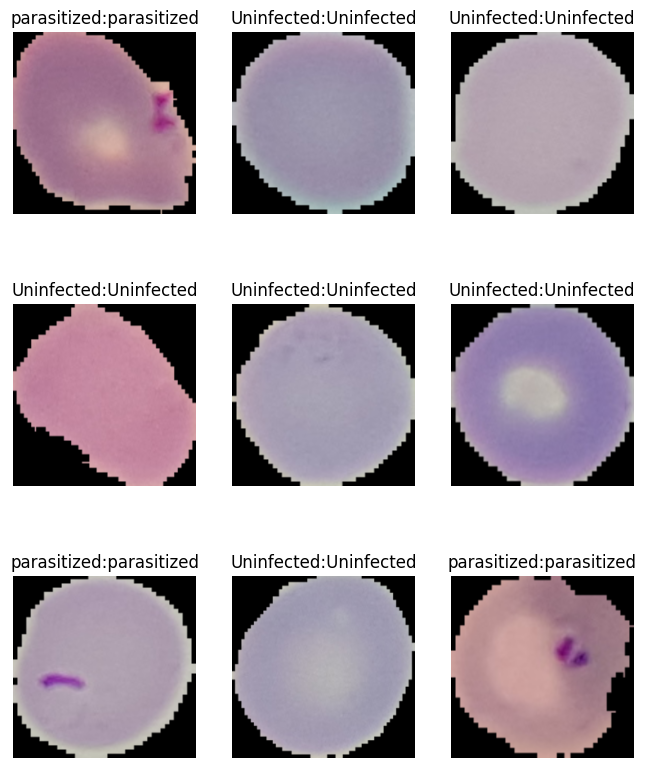

In [34]:
plt.figure(figsize=(8,10))
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(paraside_or_not(label.numpy()[0])) + ":" +str(paraside_or_not(model.predict(image)[0][0])))
  plt.axis('off')

In [35]:
y_pred = model.predict(test_dataset)

2755/2755 [==============================] - 18s 3ms/step


In [36]:
y_test = list(test_dataset.take(1).as_numpy_iterator())

In [37]:
y_test

[(array([[[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          ...,
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 

In [38]:
labels = []
images = []

for i, (image, label) in enumerate(test_dataset):
      labels.append(label.numpy()[0])
      images.append(model.predict(image)[0][0])

1/1 [==============================] - 0s 20ms/step


In [39]:
y_test = np.array(labels)
y_pred_proba = np.array(images)

In [40]:
def prediction (pred):
  if pred >=0.5 :
    return
  else:
    return 0

In [41]:
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)
print(y_pred[:10])

[1 1 1 1 1 1 1 0 1 1]


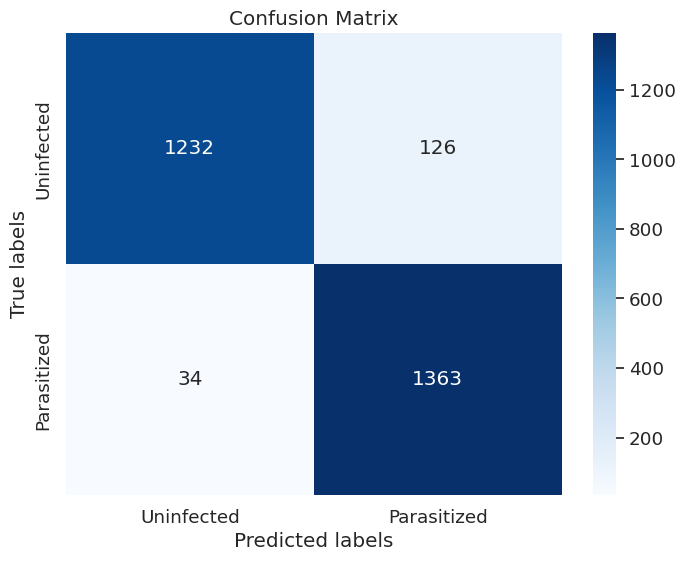

In [42]:
cm = confusion_matrix(y_test ,y_pred )
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Uninfected','Parasitized'], yticklabels=['Uninfected','Parasitized'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

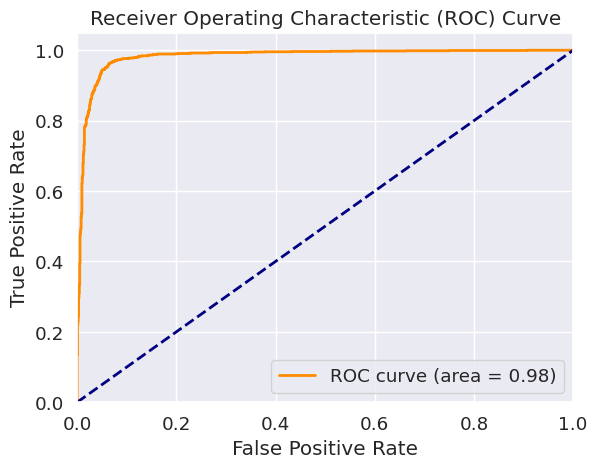

In [44]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [48]:
from sklearn.metrics import precision_score, recall_score ,f1_score , accuracy_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [49]:
print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1 score = {f1}")
print(f"accuracy score = {accuracy}")

precision = 0.9153794492948287
recall = 0.9756621331424481
f1 score = 0.9445599445599445
accuracy score = 0.941923774954628
